In [1]:
import numpy as np

In [2]:
from kymatio.numpy import Scattering2D
S = Scattering2D(J=4, L=12, max_order=1, shape=(512, 512))

In [3]:
import numpy as np 
from skimage import io
import os
import glob
img_dir = "flat cell videos/electric field" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
flat_elecfield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    flat_elecfield.append(img)
    
    
img_dir = "ridged cell videos/electricfield" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
ridged_elecfield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    ridged_elecfield.append(img)

In [3]:
import numpy as np 
from skimage import io
import os
import glob
img_dir = "flat cell videos/nofield" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
flat_nofield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    flat_nofield.append(img)
    
    
img_dir = "ridged cell videos/nofield" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
ridged_nofield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    ridged_nofield.append(img)


In [3]:
import numpy as np 
from skimage import io
import os
import glob
img_dir = "flat cell videos/electric field/train" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
flat_EFtrain = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    flat_EFtrain.append(img)
    
img_dir = "flat cell videos/electric field/test" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
flat_EFtest = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    flat_EFtest.append(img)
    
img_dir = "ridged cell videos/electricfield/train" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
ridged_EFtrain = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    ridged_EFtrain.append(img)
    
img_dir = "ridged cell videos/electricfield/test" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
ridged_EFtest = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    ridged_EFtest.append(img)
    
img_dir = "flat cell videos/nofield" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
flat_nofield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    flat_nofield.append(img)
    
img_dir = "ridged cell videos/nofield" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
ridged_nofield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    ridged_nofield.append(img)

In [4]:
flat_electricfield = flat_EFtrain + flat_EFtest
ridged_electricfield = ridged_EFtrain + ridged_EFtest

In [4]:
ridged_nofield[5].shape

(512, 512, 60)

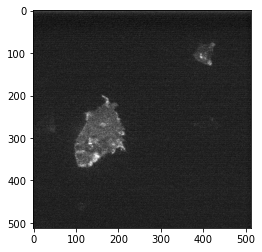

In [5]:
import matplotlib.pyplot as plt
plt.imshow(ridged_nofield[4][:,:,7], cmap='gray')
#plt.savefig('flat_wavelet.png')

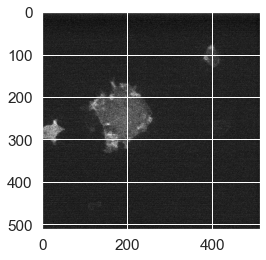

In [211]:
import matplotlib.pyplot as plt
plt.imshow(ridged_elecfield[3][:,:,0], cmap='gray')
#plt.savefig('flat_wavelet.png')

In [44]:
im = S(flat_nofield[7][:,:,0])

In [45]:
im.shape

(49, 32, 32)

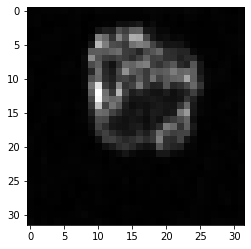

In [48]:
plt.imshow(im[36], cmap='gray')
plt.savefig('flat_wavelet3.png')

In [50]:
np.sum(np.abs(im), axis=(1,2)).shape

(49,)

In [149]:
def coding(input_list):
    X = []
    for i in range(len(input_list)):
        Y = []
        input = input_list[i] / 255.
        for j in range(input.shape[2]):
            scatt = S(input[:,:,j])
            code_scatt = (np.sum(np.abs(scatt), axis=(1,2)))/(scatt.shape[1]*scatt.shape[2])
            Y.append(code_scatt)
        Y = np.asarray(Y)
        X.append(Y)
        print('done for %i th sample' % i)
    return(X)

In [150]:
flat_EF = coding(flat_elecfield)
ridged_EF = coding(ridged_elecfield)

done for 0 th sample
done for 1 th sample
done for 2 th sample
done for 0 th sample
done for 1 th sample
done for 2 th sample
done for 3 th sample


In [216]:
len(flat_EF)

3

In [157]:
np.save('flat_EF_waveletcode.npy', flat_EF, allow_pickle=True)
np.save('ridged_EF_waveletcode.npy',ridged_EF, allow_pickle=True)

In [12]:
flat_NF = coding(flat_nofield)
ridged_NF = coding(ridged_nofield)
flat_EF = coding(flat_electricfield)
ridged_EF = coding(ridged_electricfield)

done for 0 th sample
done for 1 th sample
done for 2 th sample
done for 3 th sample
done for 4 th sample
done for 5 th sample
done for 6 th sample
done for 7 th sample
done for 8 th sample
done for 9 th sample
done for 10 th sample
done for 11 th sample
done for 0 th sample
done for 1 th sample
done for 2 th sample
done for 3 th sample
done for 4 th sample
done for 5 th sample
done for 0 th sample
done for 1 th sample
done for 2 th sample
done for 3 th sample
done for 0 th sample
done for 1 th sample
done for 2 th sample
done for 3 th sample
done for 4 th sample
done for 5 th sample
done for 6 th sample
done for 7 th sample


In [15]:
np.save('flat_EF_wavelet.npy', flat_EF, allow_pickle=True)
np.save('ridged_EF_wavelet.npy',ridged_EF, allow_pickle=True)

In [61]:
np.save('flat_wavelet_new.npy', flat, allow_pickle=True)
np.save('ridged_wavelet_new.npy',ridged, allow_pickle=True)

In [6]:
flat = np.load('flat_wavelet_new.npy', allow_pickle=True)
ridged = np.load('ridged_wavelet_new.npy', allow_pickle=True)

In [72]:
flat_EF = np.load('flat_EF_waveletcode.npy', allow_pickle=True)
ridged_EF = np.load('ridged_EF_waveletcode.npy', allow_pickle=True)

In [5]:
flat[0].shape

(95, 49)

In [7]:
flat_set1 = np.concatenate((flat[0],flat[1],flat[2],flat[3]),axis=0)
flat_set2 = np.concatenate((flat[4],flat[5],flat[6],flat[7]),axis=0)
flat_set3 = np.concatenate((flat[8],flat[9],flat[10],flat[11]),axis=0)
#ridged_set1 = np.concatenate((ridged[0],ridged[1]),axis=0)
ridged_set1 = ridged[0]
ridged_set2 = np.concatenate((ridged[2],ridged[3]),axis=0)
ridged_set3 = np.concatenate((ridged[4],ridged[5]),axis=0)

In [73]:
flat_set1 = np.concatenate((flat[0],flat[1],flat[2],flat[3],flat_EF[1]),axis=0)
flat_set2 = np.concatenate((flat[4],flat[5],flat[6],flat[7],flat_EF[0]),axis=0)
flat_set3 = np.concatenate((flat[8],flat[9],flat[10],flat[11],flat_EF[2]),axis=0)
#ridged_set1 = np.concatenate((ridged[0],ridged[1]),axis=0)
ridged_set1 = np.concatenate((ridged[0],ridged[4],ridged_EF[3]),axis=0)
ridged_set2 = np.concatenate((ridged[2],ridged[3],ridged_EF[2]),axis=0)
ridged_set3 = np.concatenate((ridged[5],ridged_EF[0],ridged_EF[1]),axis=0)

In [95]:
flat_set1 = flat_EF[1]
flat_set2 = flat_EF[0]
flat_set3 = flat_EF[2]
#ridged_set1 = np.concatenate((ridged[0],ridged[1]),axis=0)
ridged_set1 = ridged_EF[3]
ridged_set2 = ridged_EF[2]
ridged_set3 = np.concatenate((ridged_EF[0],ridged_EF[1]),axis=0)

In [8]:
flat_set1_labels = np.zeros((flat_set1.shape[0],))
flat_set2_labels = np.zeros((flat_set2.shape[0],))
flat_set3_labels = np.zeros((flat_set3.shape[0],))
ridged_set1_labels = np.ones((ridged_set1.shape[0],))
ridged_set2_labels = np.ones((ridged_set2.shape[0],))
ridged_set3_labels = np.ones((ridged_set3.shape[0],))

In [84]:
flat_set1 = np.concatenate((flat[0],flat[1],flat[2],flat[3],ridged[0],ridged[2]),axis=0)
flat_set2 = np.concatenate((flat[4],flat[5],flat[6],flat[7],ridged[5]),axis=0)
flat_set3 = np.concatenate((flat[8],flat[9],flat[10],flat[11],ridged[4],ridged[3]),axis=0)
ridged_set1 = np.concatenate((flat_EF[1],ridged_EF[2]),axis=0)
ridged_set2 = np.concatenate((flat_EF[0],flat_EF[2],ridged_EF[0]),axis=0)
ridged_set3 = np.concatenate((ridged_EF[1],ridged_EF[3]),axis=0)

In [9]:
X_test = np.concatenate((flat_set2,ridged_set2),axis=0)
y_test = np.concatenate((flat_set2_labels,ridged_set2_labels),axis=0)
X_train = np.concatenate((flat_set1,flat_set3,ridged_set1,ridged_set3),axis=0)
y_train = np.concatenate((flat_set1_labels,flat_set3_labels,ridged_set1_labels,ridged_set3_labels),axis=0)

In [145]:
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.svm import LinearSVC

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5]}               
clf = GridSearchCV(
    LinearSVC(class_weight=None, dual=False, max_iter=1000000000, penalty='l1'), param_grid
)
clf = clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 6.737s
Best estimator found by grid search:
LinearSVC(C=1, dual=False, max_iter=1000000000, penalty='l1')


In [11]:
from sklearn import svm, metrics
from sklearn.svm import LinearSVC

#classifier = LinearSVC(penalty='l1', dual=False, C=1.0, max_iter=10000)
classifier = LinearSVC(C=5000, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000000000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)
classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

classifier.score(X_test,y_test)

Classification report for classifier LinearSVC(C=5000, dual=False, max_iter=1000000000, penalty='l1'):
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94       284
         1.0       0.82      1.00      0.90       153

    accuracy                           0.92       437
   macro avg       0.91      0.94      0.92       437
weighted avg       0.94      0.92      0.92       437




0.9221967963386728

In [224]:
predicted = classifier.predict(X_train)

#print("Classification report for classifier %s:\n%s\n"
#      % (classifier, metrics.classification_report(y_train, predicted)))

classifier.score(X_train,y_train)

1.0

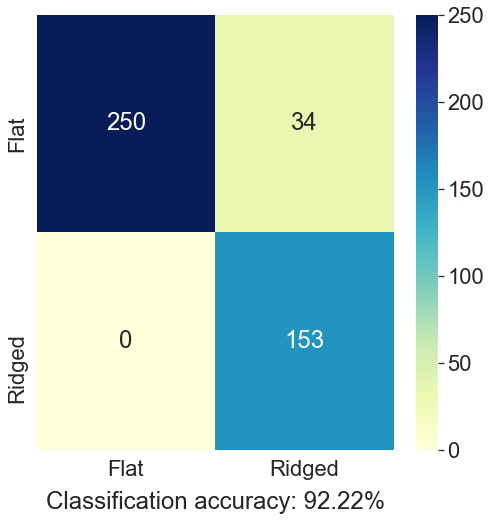

In [87]:
import seaborn as sn
import pandas as pd


a = metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
df_cm = pd.DataFrame(a, range(2), range(2))
plt.figure(figsize=(8,8))
df_cm = df_cm.rename(index={0: "Flat", 1: "Ridged"}, columns={0: "Flat", 1: "Ridged"})
#df_cm = df_cm.rename(index={0: "flat no EF", 1: "flat EF", 2: "ridged no EF", 3: "ridged EF"}, columns={0: "flat no EF", 1: "flat EF", 2: "ridged no EF", 3: "ridged EF"})
sn.set(font_scale=2.0) # for label size
sn.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt='.0f') # font size
plt.title('Classification accuracy: 92.22%', y = -0.15)
plt.savefig('wavelet_classify2.png',bbox_inches='tight', dpi=150)
plt.show()

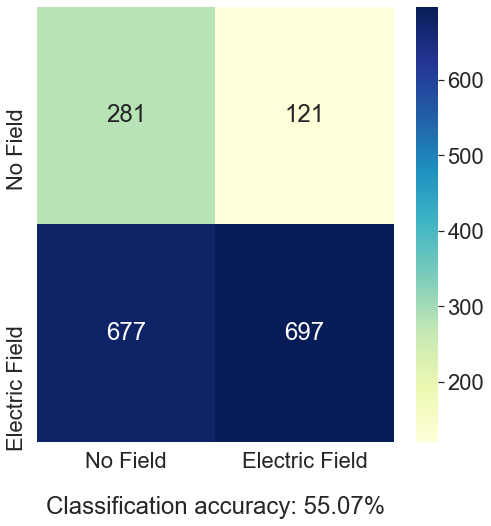

In [94]:
import seaborn as sn
import pandas as pd


a = metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
df_cm = pd.DataFrame(a, range(2), range(2))
plt.figure(figsize=(8,8))
df_cm = df_cm.rename(index={0: "No Field", 1: "Electric Field"}, columns={0: "No Field", 1: "Electric Field"})
#df_cm = df_cm.rename(index={0: "flat no EF", 1: "flat EF", 2: "ridged no EF", 3: "ridged EF"}, columns={0: "flat no EF", 1: "flat EF", 2: "ridged no EF", 3: "ridged EF"})
sn.set(font_scale=2.0) # for label size
sn.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt='.0f') # font size
plt.title('Classification accuracy: 55.07%', y = -0.18)
plt.savefig('wavelet_classify_EFNF3.png')
plt.show()

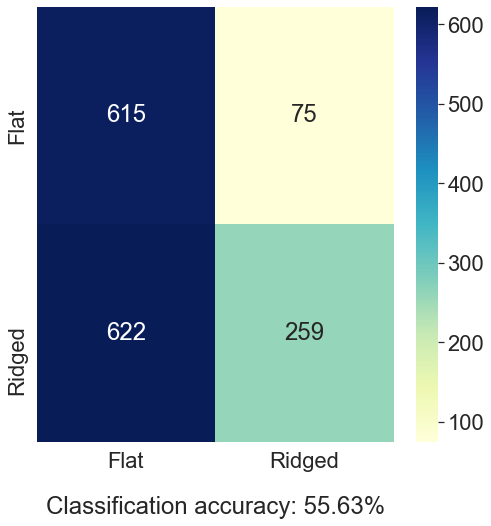

In [83]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

a = metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
df_cm = pd.DataFrame(a, range(2), range(2))
plt.figure(figsize=(8,8))
df_cm = df_cm.rename(index={0: "Flat", 1: "Ridged"}, columns={0: "Flat", 1: "Ridged"})
#df_cm = df_cm.rename(index={0: "flat no EF", 1: "flat EF", 2: "ridged no EF", 3: "ridged EF"}, columns={0: "flat no EF", 1: "flat EF", 2: "ridged no EF", 3: "ridged EF"})
sn.set(font_scale=2.0) # for label size
sn.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt='.0f') # font size
plt.title('Classification accuracy: 55.63%', y = -0.18)
plt.savefig('wavelet_classify1.png')
plt.show()

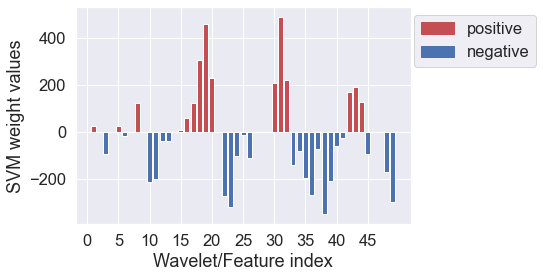

In [90]:
def bar_color(df,color1,color2):
    return np.where(df>0,color1,color2).T

colors = {'positive':'r', 'negative':'b'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

coef = np.reshape(classifier.coef_,(49,))
code_size = np.arange(1,X_train.shape[1]+1)
plt.bar(code_size,(coef), color=bar_color(coef,'r','b')) #color='g')
plt.xticks(np.arange(0,50, step = 5.0))
plt.xlabel('Wavelet/Feature index')
sn.set(font_scale=1.5)
#plt.bar(code_size,coef, color='y')
plt.ylabel('SVM weight values')
plt.legend(handles, labels, bbox_to_anchor=(1.4, 1.0))
#plt.legend(['positive','negative'],
           #bbox_to_anchor=(1.0, 1.0))
#plt.title('SVM weights')
#plt.savefig("dictionary_svm.pdf")
plt.savefig('wavelet_svm.jpg',bbox_inches='tight', dpi=150)
plt.show()

In [66]:
S.L

12

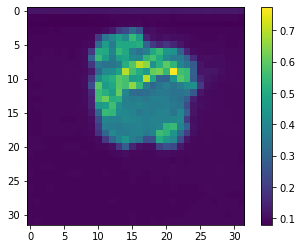

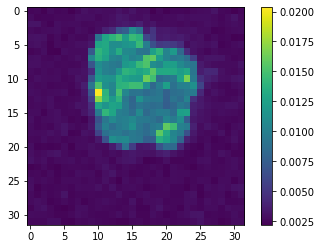

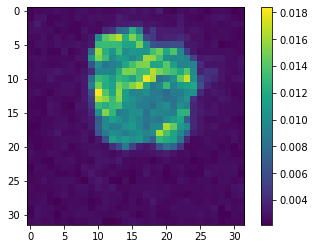

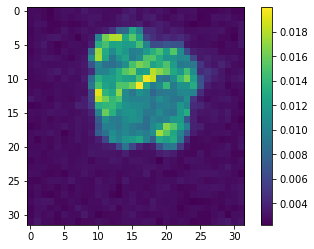

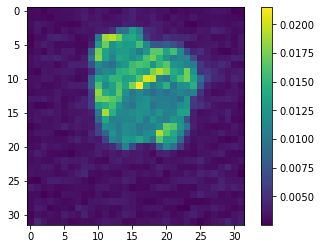

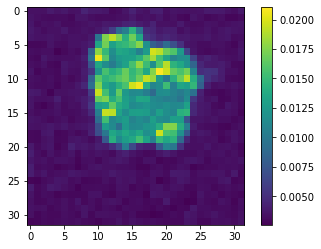

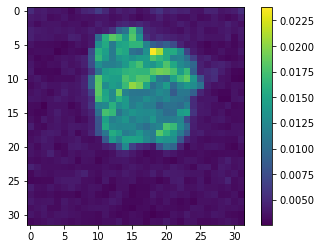

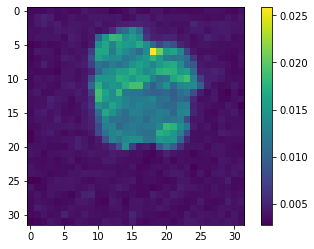

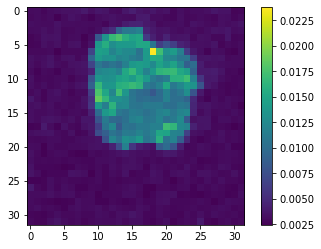

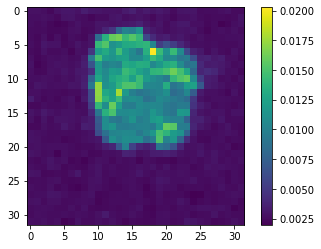

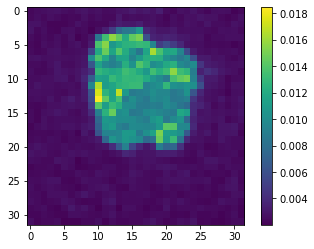

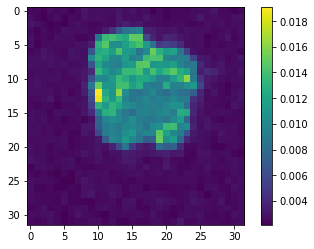

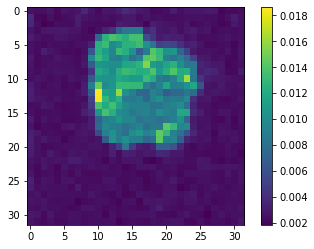

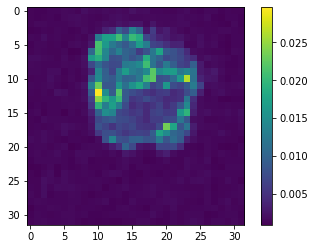

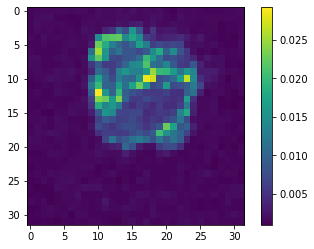

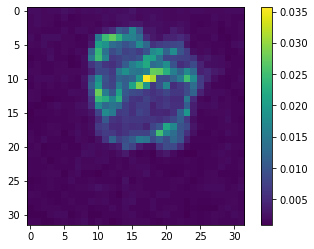

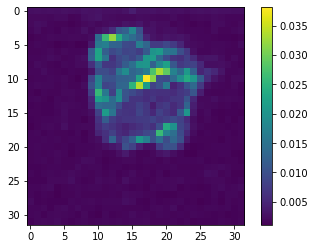

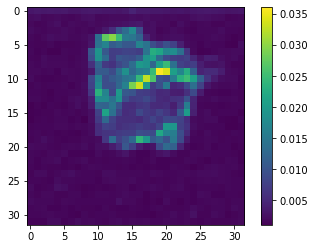

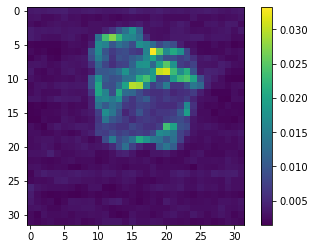

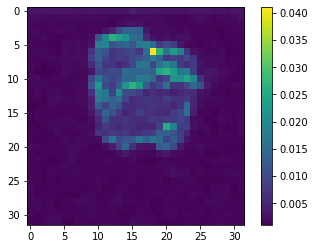

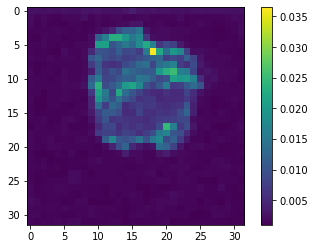

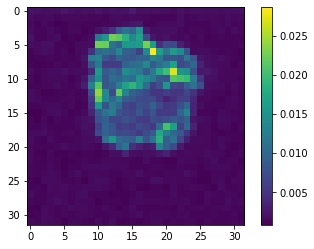

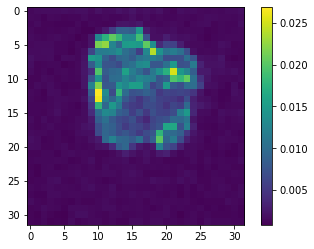

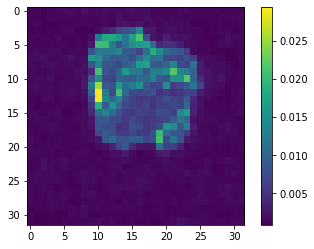

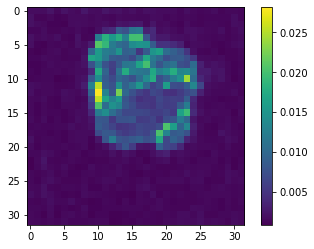

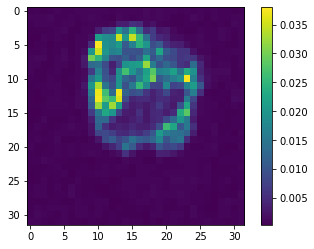

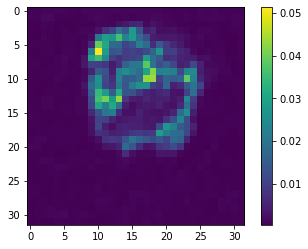

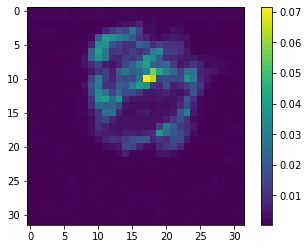

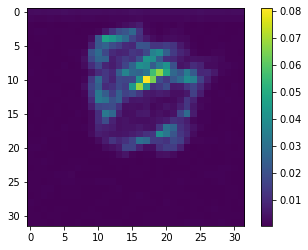

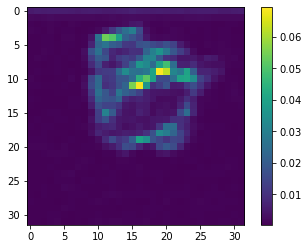

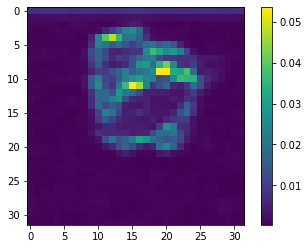

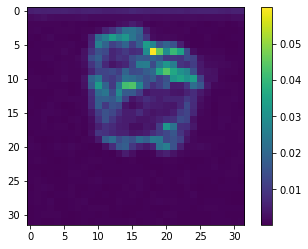

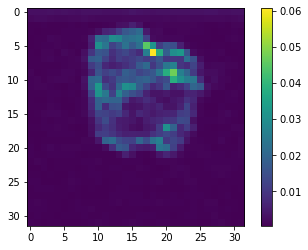

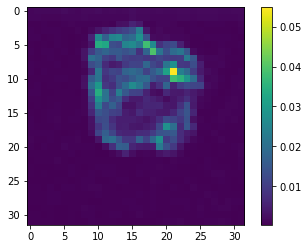

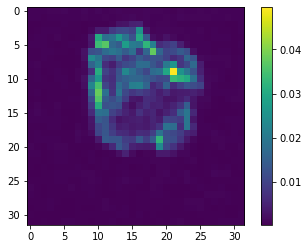

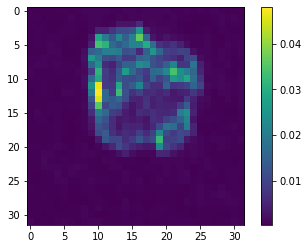

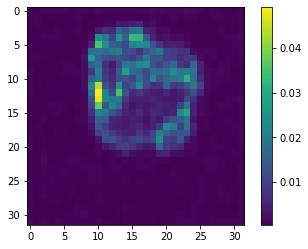

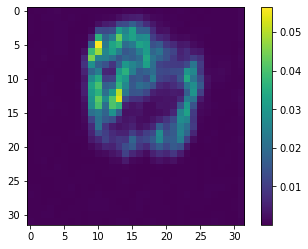

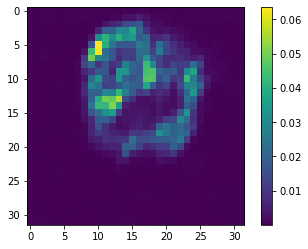

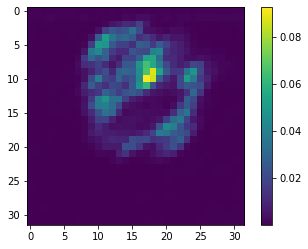

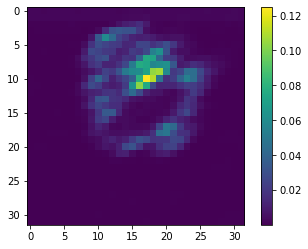

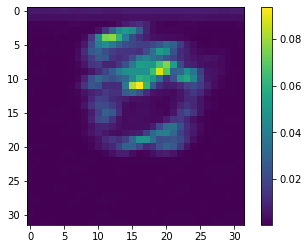

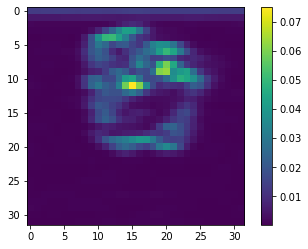

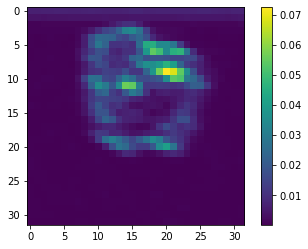

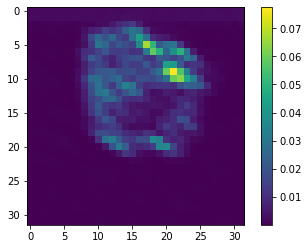

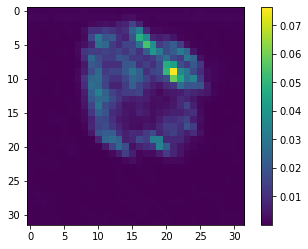

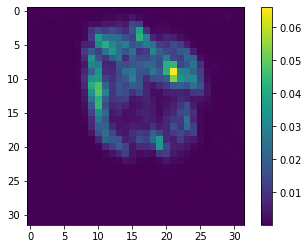

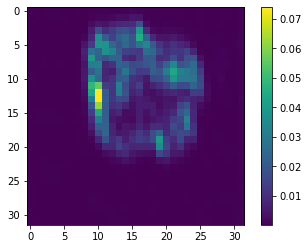

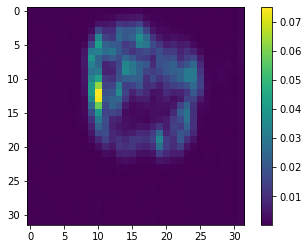

In [69]:
scatt_flat = S(im2[0])

for i in range(scatt_flat.shape[0]):
    img_fltd = np.abs(scatt_flat[i])
    plt.imshow(img_fltd, vmin=img_fltd.min(), vmax=img_fltd.max())
    plt.colorbar()
    plt.show()

In [91]:
score_train = np.zeros(X_train.shape[0],)
for i in range(score_train.shape[0]):
    score_train[i] = np.dot(coef, X_train[i]) + classifier.intercept_

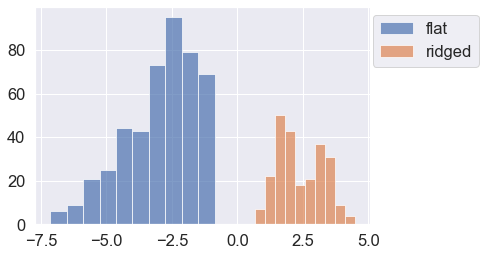

In [95]:
Features=['flat','ridged']
num = y_train.shape[0]-np.count_nonzero(y_train)
plt.hist(score_train[0:num], alpha=0.7)
plt.hist(score_train[num:], alpha=0.7)
#plt.title('SVM score histogram for training set')
sn.set(font_scale=1.5)
#plt.legend(Features,loc=1)
plt.legend(Features,
           bbox_to_anchor=(1.35, 1.0))
#plt.savefig("SVMscoredict_train.png")
plt.savefig('SVMscore_train.png',bbox_inches='tight', dpi=150)
plt.show()

In [96]:
score_test = np.zeros(X_test.shape[0],)
for i in range(score_test.shape[0]):
    score_test[i] = np.dot(coef, X_test[i]) + classifier.intercept_

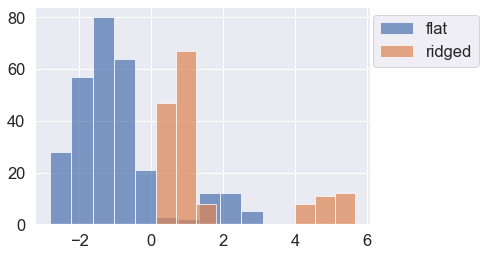

In [98]:
Features=['flat','ridged']
num = y_test.shape[0]-np.count_nonzero(y_test)
plt.hist(score_test[0:num], alpha=0.7)
plt.hist(score_test[num:], alpha=0.7)
#plt.title('SVM score histogram for test set')
#plt.legend(Features,loc=1)
plt.legend(Features,
           bbox_to_anchor=(1.35, 1.0))
#plt.savefig("SVMscoredict_test.png")
plt.savefig('SVMscore_test.png',bbox_inches='tight', dpi=150)
plt.show()

This is where we execute